In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import lightgbm
from lightgbm import LGBMClassifier

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


Bad key "text.kerning_factor" on line 4 in
C:\Users\gouth\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import string as st
import re
import nltk
from nltk import PorterStemmer, WordNetLemmatizer
# nltk.download('stopwords')
# nltk.download('wordnet')

In [3]:
train_df = pd.read_csv('./option1-data/train.csv')
test_df = pd.read_csv('./option1-data/test.csv')

In [6]:
print(train_df.shape)
train_df.head()

(256442, 6)


,id,tid1,tid2,title1_en,title2_en,label
0,195611,0,1,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated
1,191474,2,3,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated
2,25300,2,4,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated
3,123757,2,8,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP overtakes Hong Kong? Bureau of ...,unrelated
4,141761,2,11,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outpaces Hong Kong? Defending R...,unrelated


#### Creating new column which is concatenation of title1_en and title2_en

In [7]:
train_df['title_1_2'] = train_df['title1_en'] + train_df['title2_en']

#### Generating a word cloud image on the newly created column

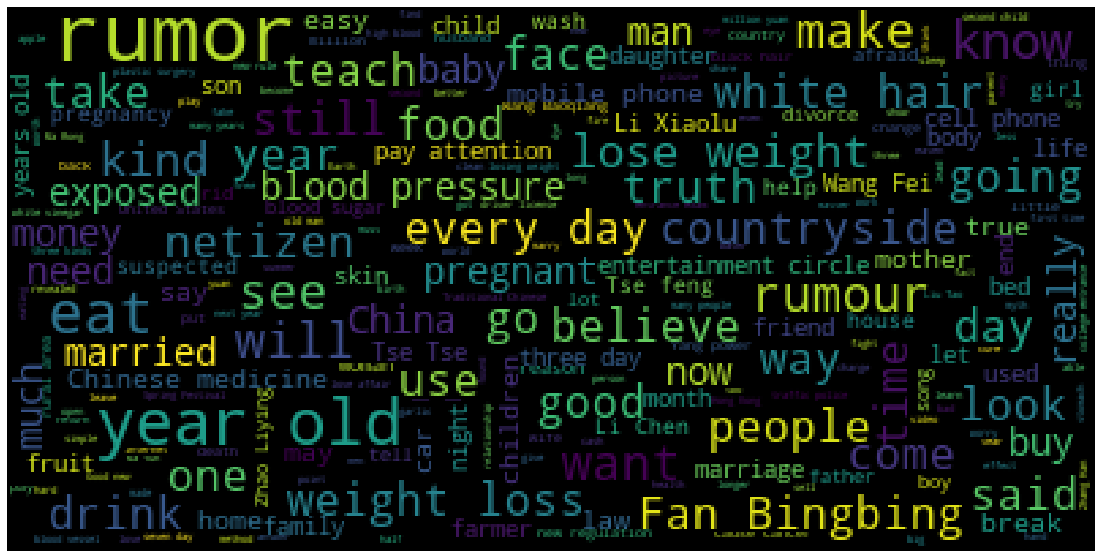

In [8]:
from wordcloud import WordCloud, ImageColorGenerator

text = " ".join([x for x in train_df['title_1_2']])
#generate a word cloud image:
wordcloud = WordCloud(max_font_size=30, max_words=1000).generate(text)

# Display the generated image:
plt.figure(figsize= [20,10])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Target value label distribution with respect to the labels unrelated, agreed and disagreed

unrelated    175598
agreed        74238
disagreed      6606
Name: label, dtype: int64


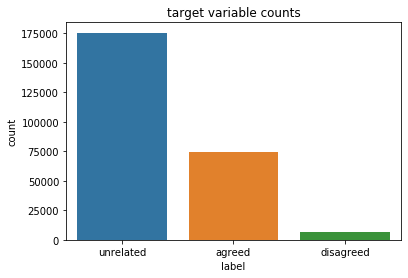

In [10]:
print(train_df.label.value_counts())
sns.countplot(x = 'label',data = train_df)
plt.title('target variable counts')
plt.show()

#### Checking if there are any null values in the training dataset and test dataset

In [8]:
#null values
print(train_df.isna().sum())
print(test_df.isna().sum())

id           0
tid1         0
tid2         0
title1_en    0
title2_en    0
label        0
title_1_2    0
dtype: int64
id           0
tid1         0
tid2         0
title1_en    0
title2_en    0
dtype: int64


In [11]:
tf = TfidfVectorizer(stop_words='english',token_pattern='(?ui)\\b\\w*[a-z]+\\w*\\b')    

# Cross Validation

In [10]:
def cv_model(fit_obj,df):
    score = []
    i = 1
    cv = KFold(n_splits = 5,random_state = 60609,shuffle = True)
    for train_index, test_index in cv.split(df):
        x_train,y_train = df['title_1_2'].loc[train_index],df['label'].loc[train_index]
        x_val,y_val = df['title_1_2'].loc[train_index],df['label'].loc[train_index]
        tf = TfidfVectorizer(stop_words='english',token_pattern='(?ui)\\b\\w*[a-z]+\\w*\\b')
        tf.fit(x_train)
        train_final = tf.transform(x_train)
        le = LabelEncoder()
        le.fit(y_train)
        y_train = le.transform(y_train)
        #print("Model Training")
        fit_obj.fit(train_final, y_train)
        val_final = tf.transform(x_val)
        y_val = le.transform(y_val)
        #print("Model Predictions")
        y_pred = fit_obj.predict(val_final)
        score.append(accuracy_score(y_val,y_pred))
        #print("accuracy score for fold {} is {}".format(i,score[i-1]))
        i += 1
    return np.mean(score)
    

In [11]:
xgb = XGBClassifier()
lgbm = LGBMClassifier()
nb = MultinomialNB()

print("xg boosting:{}".format(cv_model(xgb,train_df)))
print("light gbm:{}".format(cv_model(lgbm,train_df)))
print("multinomial NB:{}".format(cv_model(nb,train_df)))

xg boosting:0.7917921021878239
light gbm:0.7853471755183488
multinomial NB:0.7633577958282728


### Dividing the training dataset into training(0.70) and validation datasets(0.30) by setting the random state = 60609

In [12]:
x_train,x_val, y_train, y_val = train_test_split(train_df['title_1_2'],train_df.label, test_size = 0.30,random_state = 60609)

In [13]:
tf.fit(x_train)
train_final = tf.transform(x_train)

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_val = le.transform(y_val)

In [16]:
test_final = tf.transform(x_val)

In [17]:
xgb = XGBClassifier()
xgb.fit(train_final, y_train)

print('XGBoost Classifier model fitted..')
pred = xgb.predict(test_final)
print("Accuracy score : {}".format(accuracy_score(y_val, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_val, pred)))

XGBoost Classifier model fitted..
Accuracy score : 0.7670310529941637
Confusion matrix : 
 [[ 8450    13 13780]
 [   40   311  1597]
 [ 2424    69 50249]]


In [18]:
lgbm = LGBMClassifier()
lgbm.fit(train_final, y_train)

print('LightGBM Classifier model fitted..')
pred = lgbm.predict(test_final)
print("Accuracy score : {}".format(accuracy_score(y_val, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_val, pred)))

LightGBM Classifier model fitted..
Accuracy score : 0.7728932967647173
Confusion matrix : 
 [[ 9474    21 12748]
 [   41   283  1624]
 [ 2977    61 49704]]


In [19]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(train_final, y_train)

print('Naive Bayes Classifier model fitted..')
pred = clf.predict(test_final)
print("Accuracy score : {}".format(accuracy_score(y_val, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_val, pred)))

Naive Bayes Classifier model fitted..
Accuracy score : 0.7476895480483018
Confusion matrix : 
 [[ 6960     1 15282]
 [    4    40  1904]
 [ 2215     5 50522]]


In [27]:
test_df['combined'] = test_df['title1_en'] + test_df['title2_en']
test_final = tf.transform(test_df['combined'])
sub_df = pd.read_csv('./option1-data/sample_submission.csv')
sub_df.label = lgbm.predict(test_final)
sub_df.label = le.inverse_transform(sub_df.label)
sub_df.to_csv('submission.csv',index = False)